# Riparian litter WEP in response to grazing

Alex Koiter

## Load Libraries

In [ ]:
library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

This is DHARMa 0.4.6. For overview type '?DHARMa'. For recent changes, type news(package = 'DHARMa')

Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'

Loading required package: viridisLite

## Read in data

In [ ]:
conc <- read_csv(here::here("./notebooks/P_concentration.csv"))


Rows: 1141 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): sample_type, timing, plot, location, treatment
dbl (3): site, ak_content, year

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 576 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): sample_type, timing, plot, location, treatment
dbl (3): site, dryweight, year

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

## Merge data

In [ ]:
veg_data <- mass_data %>%
  right_join(conc) %>%
  rename(conc = ak_content) %>% # mg/kg
  mutate(p_total = conc * dryweight/1000 /0.25) # mg/m2


Joining with `by = join_by(sample_type, site, timing, plot, location, year,
treatment)`

## Litter data

In [ ]:
litter_diff <- veg_data %>%
  filter(sample_type == "Litter") %>%
  mutate(dryweight = dryweight/1000 /0.25) %>%
  pivot_longer(cols = c(dryweight, p_total, conc), names_to = "measure", values_to = "value") %>%
  pivot_wider(names_from = timing, values_from = value) %>%
  mutate(diff = Before - After) 


## Litter Analysis

### P-total

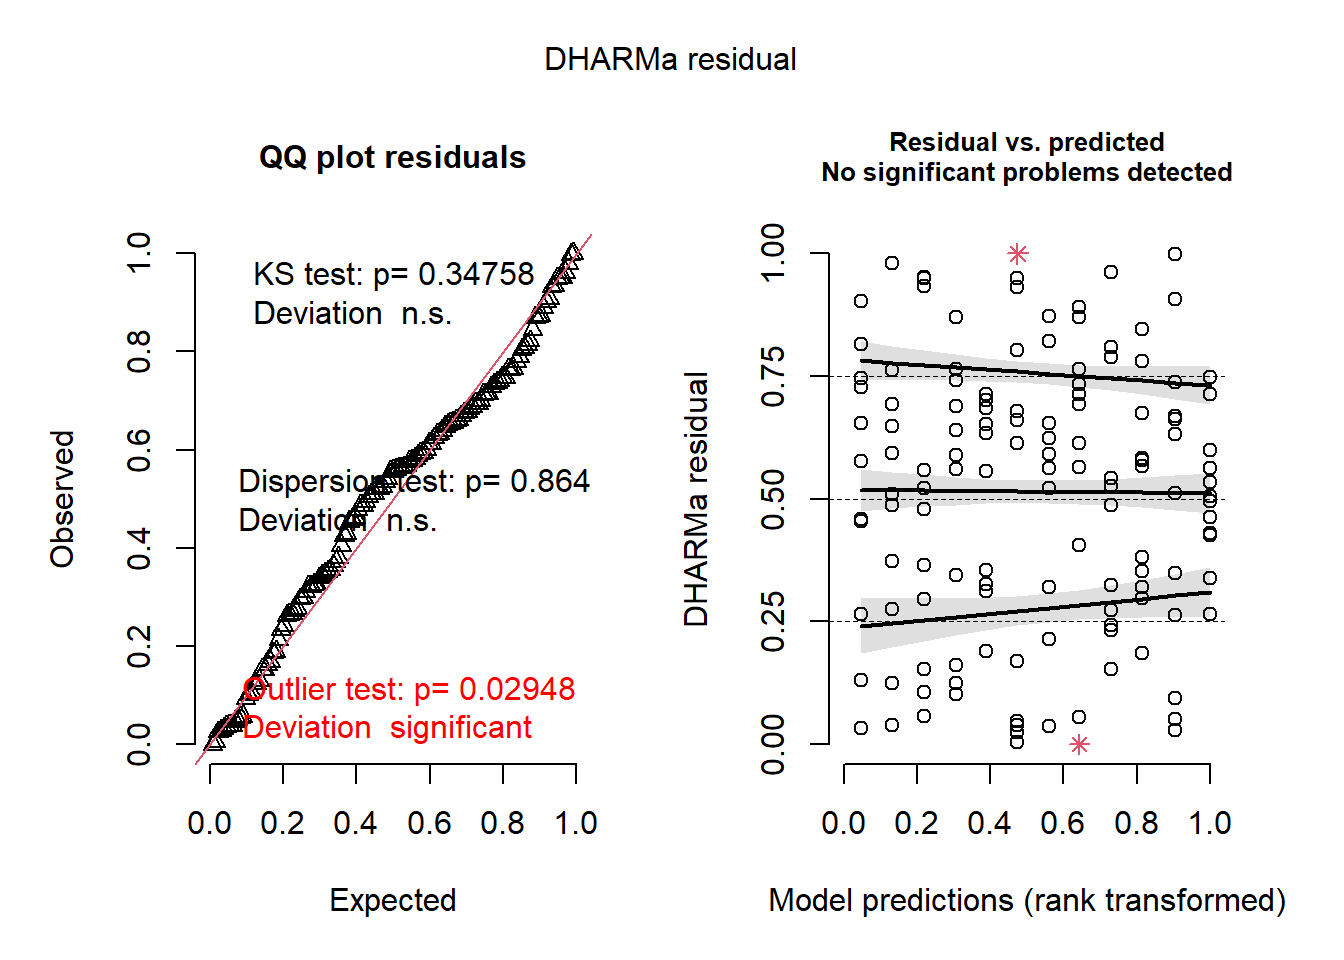

Object of Class DHARMa with simulated residuals based on 1000 simulations with refit = FALSE . See ?DHARMa::simulateResiduals for help. 
 
Scaled residual values: 0.78 0.652 0.998 0.43 0.789 0.365 0.765 0.871 0.046 0.873 0.903 0.276 0.639 0.764 1 0.845 0.556 0.028 0.655 0.815 ...

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: diff
                    Chisq Df Pr(>Chisq)  
(Intercept)        2.8104  1    0.09366 .
treatment          2.3626  3    0.50064  
location           2.4069  2    0.30015  
treatment:location 3.3583  6    0.76271  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

In [ ]:
m4 <- glmmTMB(diff ~ treatment * location + (1|site) + (1|year),
             data = filter(litter_diff, measure == "p_total"))
simulateResiduals(m4, n = 1000, plot = TRUE) 


Removing interaction

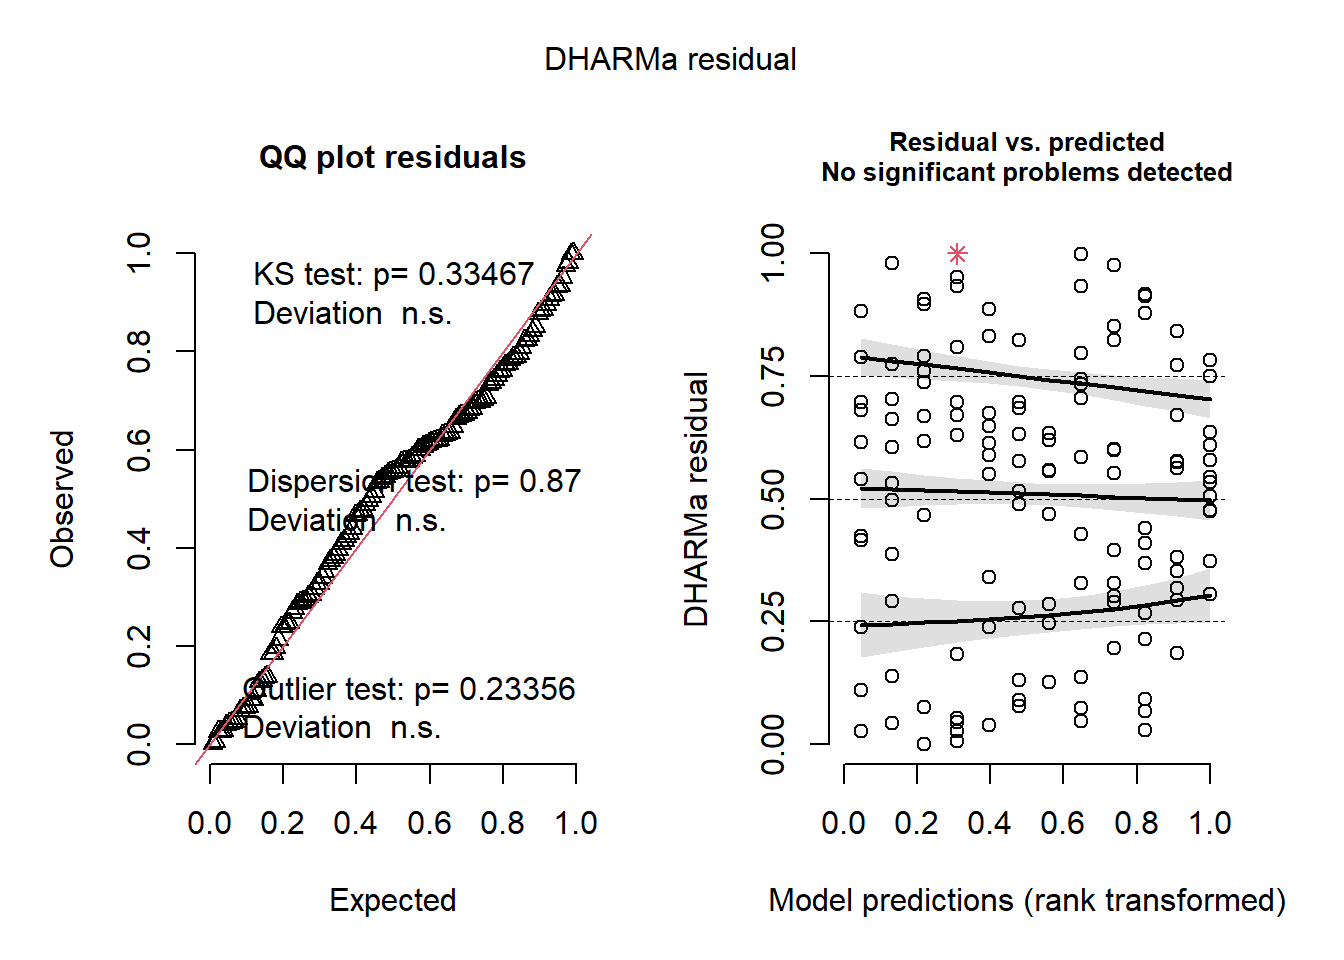

Object of Class DHARMa with simulated residuals based on 1000 simulations with refit = FALSE . See ?DHARMa::simulateResiduals for help. 
 
Scaled residual values: 0.773 0.556 0.999 0.475 0.824 0.268 0.697 0.896 0.053 0.886 0.883 0.291 0.576 0.791 1 0.842 0.469 0.046 0.675 0.788 ...

# Check for Multicollinearity

Low Correlation

      Term  VIF  VIF 95% CI Increased SE Tolerance Tolerance 95% CI
 treatment 1.00 [1.00, Inf]         1.00      1.00     [0.00, 1.00]
  location 1.00 [1.00, Inf]         1.00      1.00     [0.00, 1.00]

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: diff
             Chisq Df Pr(>Chisq)
(Intercept) 0.9539  1     0.3287
treatment   4.3023  3     0.2306
location    1.1541  2     0.5615

In [ ]:
temp4 <- filter(litter_diff, measure == "p_total") ## otherwise issue with emmeans()
m4 <- glmmTMB(diff ~ treatment + location + (1|site) + (1|year),
             data = temp4)
simulateResiduals(m4, n = 1000, plot = TRUE)


### Summary

In [ ]:
litter_diff %>%
  filter(measure == "p_total") %>%
  group_by(treatment) %>%
  summarise(median = median(diff, na.rm =T),
            mean = mean(diff, na.rm =T))


# A tibble: 4 × 3
  treatment     median  mean
  <chr>          <dbl> <dbl>
1 Control        -1.05 -2.22
2 High Graze     -1.39 -2.36
3 Mow            -5.70 -7.94
4 Regular Graze  -1.66 -6.05

# A tibble: 3 × 3
  location median  mean
  <chr>     <dbl> <dbl>
1 Lower     -5.88 -5.53
2 Middle    -2.44 -5.56
3 Upper     -1.22 -2.72

### Plots

Reorder factors

In [ ]:
plot_data <- litter_diff %>% 
  mutate(treatment = fct_recode(treatment, "Graze" = "Regular Graze")) %>%
  mutate(treatment = fct_relevel(treatment, c("Control", "Graze", "High Graze", "Mow"))) %>%
  mutate(location = fct_relevel(location, c("Upper", "Middle", "Lower")))


Extra

In [ ]:
df <- data.frame(x1 = c(-Inf, -Inf), x2 = c(Inf, Inf), y2 = c(Inf, 0), y1 = c(0, -Inf), difference = c("Net removal", "Net addition")) %>%
  mutate(difference = fct_relevel(difference, c("Net removal", "Net addition"))) 


Plots

(`stat_boxplot()`).

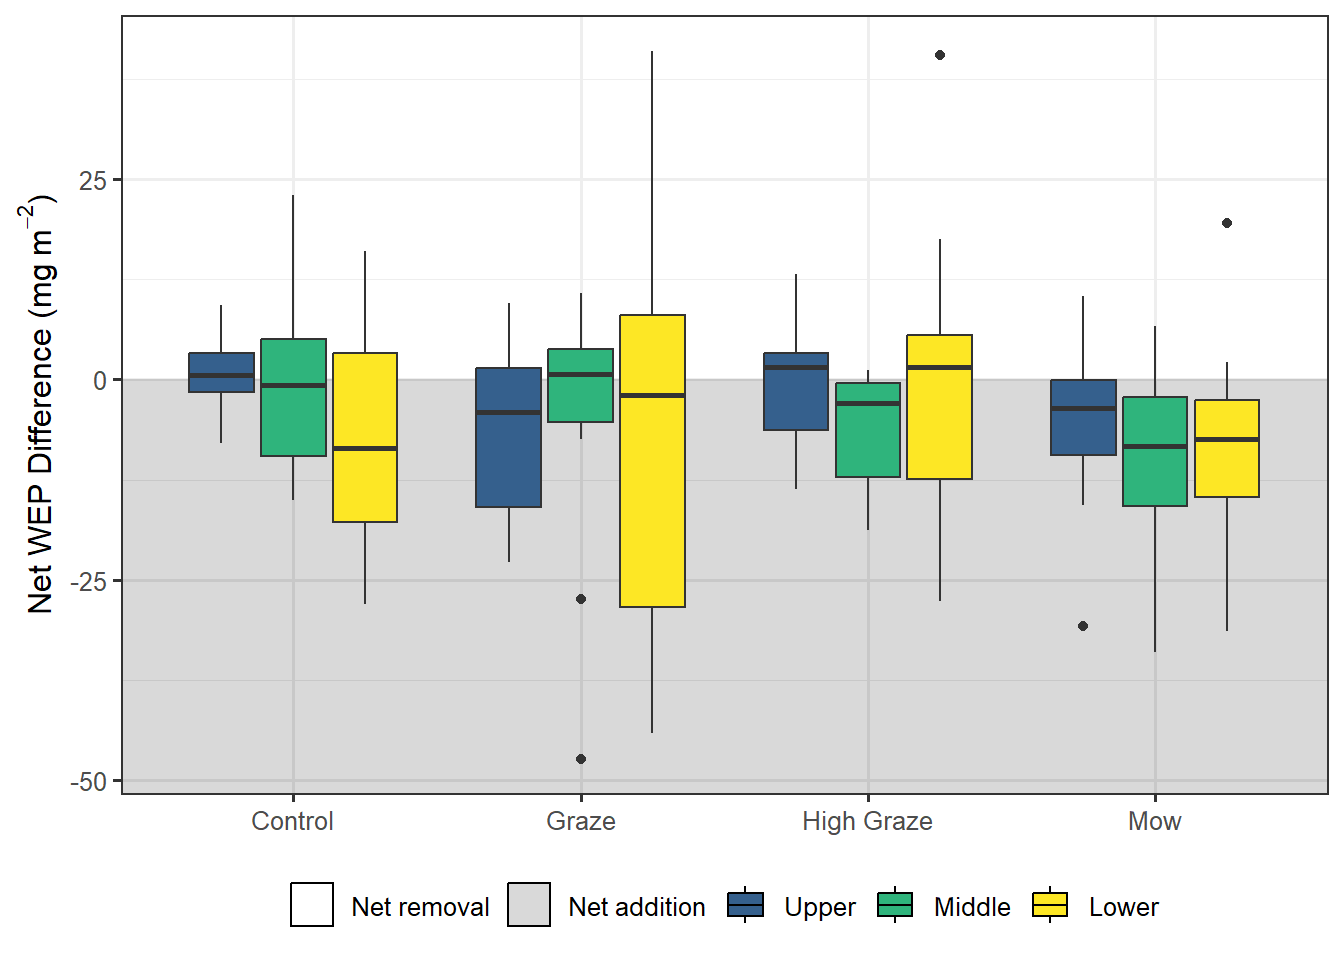

In [ ]:
#|
p1 <- ggplot(data = filter(plot_data, measure == "p_total")) +
  theme_bw(base_size = 12) +
  geom_rect(data = df, aes(xmin = x1, xmax = x2, ymin = y1, ymax = y2, fill = difference), alpha = 0.15) +
  #scale_fill_manual(values = c("white", "black")) +
  #ggnewscale::new_scale_fill() +
  geom_boxplot(aes(x = treatment, y = diff, fill = location)) +
  labs(y = expression(paste("Net WEP Difference (", mg~m^{-2}, ")")), x = "Treatment") +
  #scale_fill_viridis_d(name = "Location", begin = 0.3, end = 1) +
  scale_fill_manual(values = c("white", "black", "#35608DFF", "#2FB47CFF", "#FDE725FF")) +
  guides(fill = guide_legend(override.aes = list(colour = "black", size = 1))) +
  theme(axis.title.x = element_blank(),
        axis.text.x = element_text(angle = 0, vjust = 1, hjust = 0.5),
        legend.position = "bottom",
        legend.title = element_blank())
p1
